## Human Resource Analytics
###### Definition of Target and Outcome Window
###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy
    - H-L Test for Accuracy by segments (Not done in this notebook)
###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
%matplotlib inline

In [3]:
## HR Analytics Data
## left = 1 for attrited employees as of a particular date and 0 otherwise
## here target is attrition indicator and Performance Window is 'ever attrited' i.e. non-fixed window
hrdf = pd.read_csv("D:/AdityaData/hr_comma_sep.csv")
hrdf.columns
hrdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


#### 1.1 Data Pre-Processing
 - Missing Value Treatment

In [4]:
# a. Separating out Categorical and Numerical Variables
cat_list = []
num_list = []

for variable in hrdf.columns:
    if hrdf[variable].dtype.name in ['object']:
        cat_list.append(variable)
    else:
        num_list.append(variable)

##print("Categorical Variables : ", cat_list, '\n')
##print("Numerical Variables : ", num_list)

for i in cat_list:
    a = hrdf[i].fillna('Missing')
    print("\nThe distinct categories of variable '{0}' is :\n ".format(i), a.value_counts(), '\n')

nmiss_df = hrdf.isnull().sum(axis=0)
nmiss_df.name = 'NMiss'
print("The conclusion is that none of the categorical or numerical variable requires missing values treatment \n")
pd.concat([hrdf.describe().T,nmiss_df], axis=1,join='inner')


The distinct categories of variable 'department' is :
  sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64 


The distinct categories of variable 'salary' is :
  low       7316
medium    6446
high      1237
Name: salary, dtype: int64 

The conclusion is that none of the categorical or numerical variable requires missing values treatment 



,count,mean,std,min,25%,50%,75%,max,NMiss
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0,0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0,0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0,0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0,0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0,0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0,0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0,0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0,0


#### 1.2 Data Pre-Processing
 - Outlier Treatment
 - Frequency Analysis

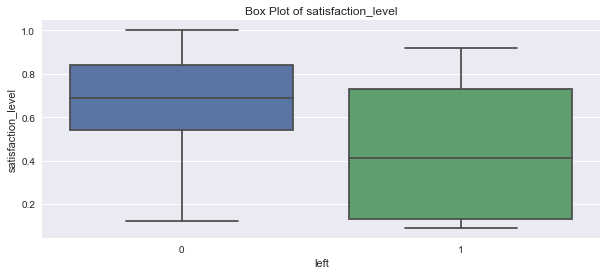

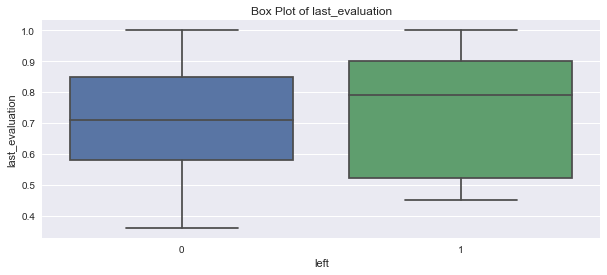

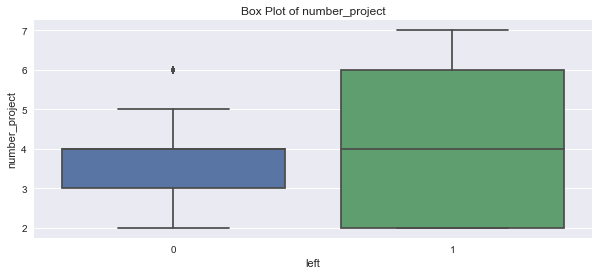

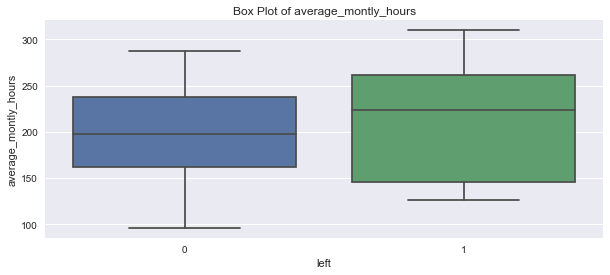

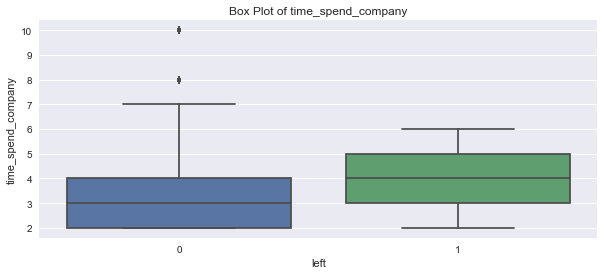

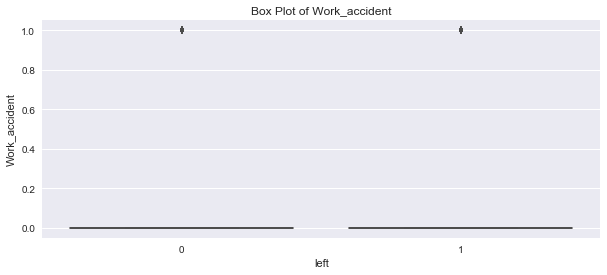

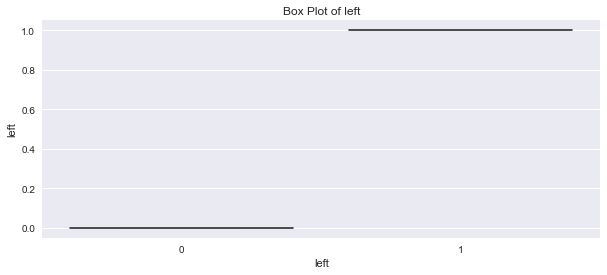

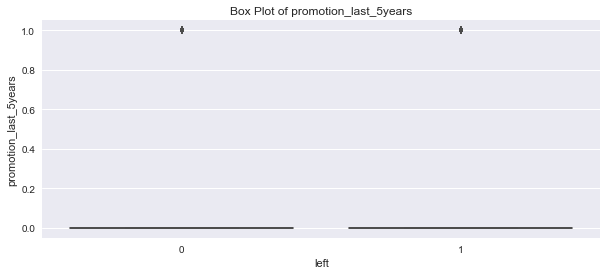

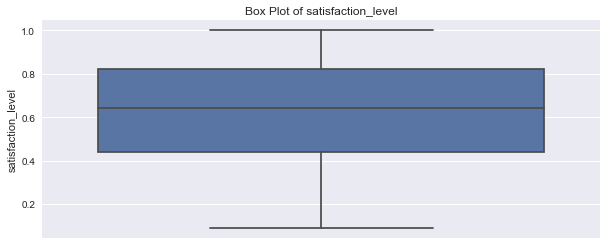

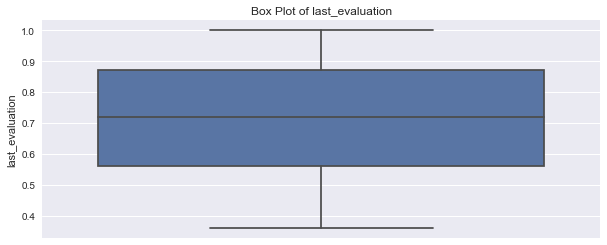

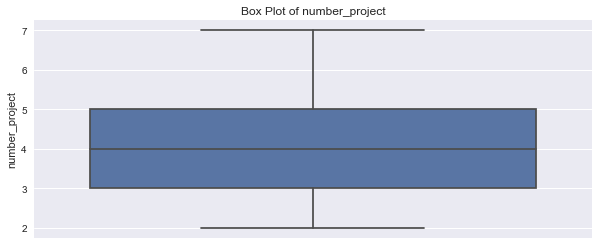

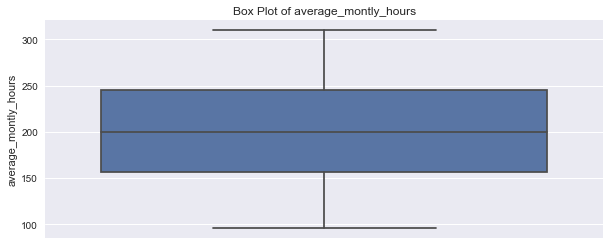

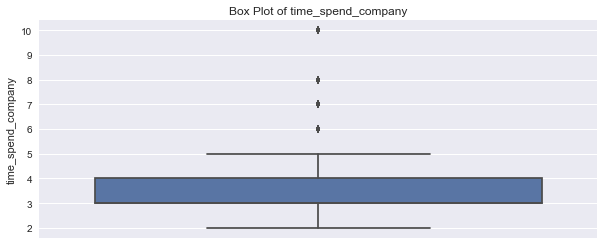

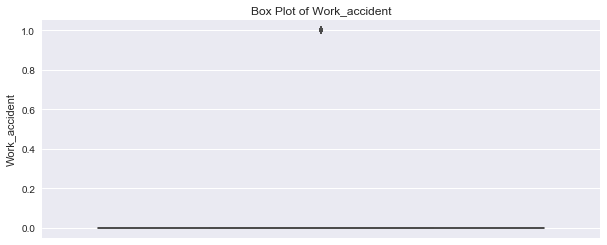

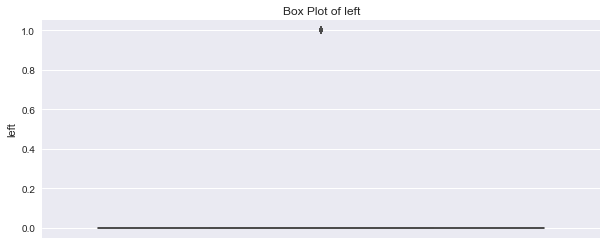

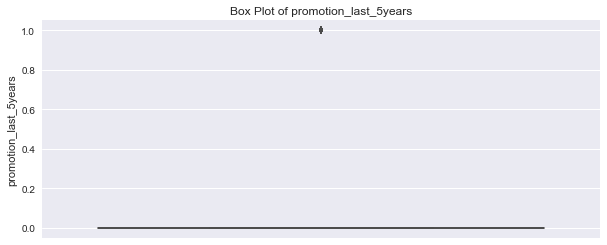

In [5]:
bp = PdfPages('BoxPlots with Attrition Split.pdf')

for num_variable in num_list:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='left', y=num_variable, data = hrdf)
    sns.plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

bp = PdfPages('BoxPlots with Total View.pdf')

for num_variable in num_list:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(y=num_variable, data = hrdf)
    sns.plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

In [6]:
## only 'time_spend_company' requires outlier treatment
hrdf['time_spend_company'] = hrdf['time_spend_company'].clip_upper(threshold=8)

###### 2.1 Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)

In [7]:
## Categorical Variable
chisq_df = pd.DataFrame()
for cat_variable in cat_list:
    cross_tab = pd.crosstab(hrdf[cat_variable],hrdf['left'], margins=False)
    stats.chi2_contingency(observed=cross_tab)[1]
    temp = pd.DataFrame([cat_variable,stats.chi2_contingency(observed=cross_tab)[0],stats.chi2_contingency(observed=cross_tab)[1] ]).T
    temp.columns = ['Variable', 'ChiSquare','P-Value']
    chisq_df = pd.concat([chisq_df, temp], axis=0, ignore_index=True)
    
print(chisq_df, '\n')

## Numerical Variable
tstats_df = pd.DataFrame()
for num_variable in num_list:
    tstats = stats.ttest_ind(hrdf[hrdf['left']==1][num_variable],hrdf[hrdf['left']==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)

print(tstats_df)

     Variable ChiSquare      P-Value
0  department   86.8255  7.04213e-15
1      salary   381.225  1.65209e-83 

           Variable Name T-Statistic      P-Value
0     satisfaction_level    -51.6128            0
1        last_evaluation    0.804242      0.42127
2         number_project     2.91386   0.00357521
3   average_montly_hours     8.75225   2.3113e-18
4     time_spend_company     20.9598   3.6393e-96
5          Work_accident    -19.1658  6.61305e-81
6                   left         inf            0
7  promotion_last_5years     -7.5812  3.62405e-14


###### 2.2 Data Exploratory Analysis
    - Visualization of variable importance

C:\Users\Neha\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Neha\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


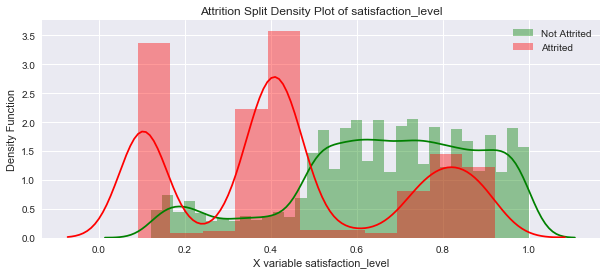

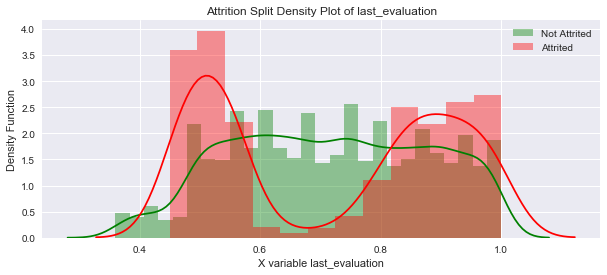

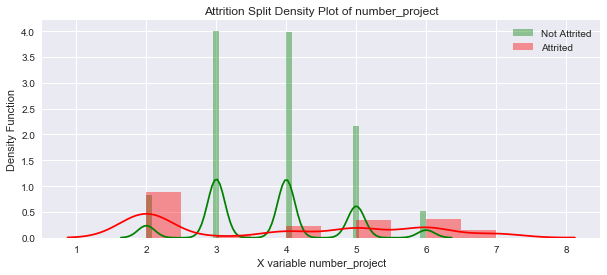

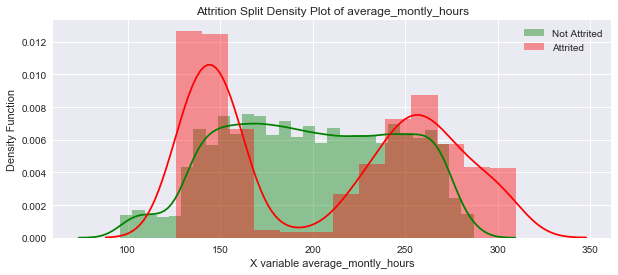

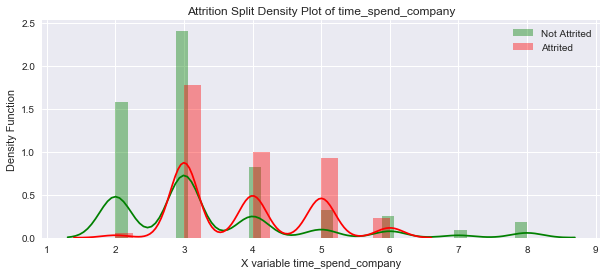

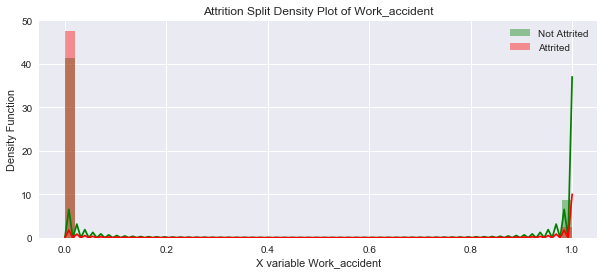

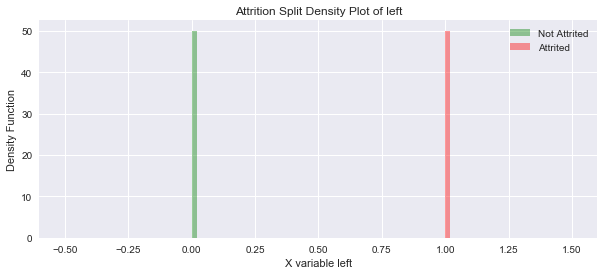

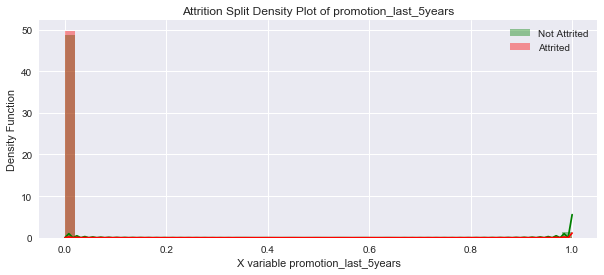

In [8]:
bp = PdfPages('Density Plots with Attrition Split.pdf')

for num_variable in num_list:
    fig,axes = plt.subplots(figsize=(10,4))
    #sns.distplot(hrdf[num_variable], kde=False, color='g', hist=True)
    sns.distplot(hrdf[hrdf['left']==0][num_variable], label='Not Attrited', color='g', hist=True, norm_hist=False)
    sns.distplot(hrdf[hrdf['left']==1][num_variable], label='Attrited', color='r', hist=True, norm_hist=False)
    sns.plt.xlabel(str("X variable ") + str(num_variable) )
    sns.plt.ylabel('Density Function')
    sns.plt.title(str('Attrition Split Density Plot of ')+str(num_variable))
    sns.plt.legend()
    bp.savefig(fig)

bp.close()

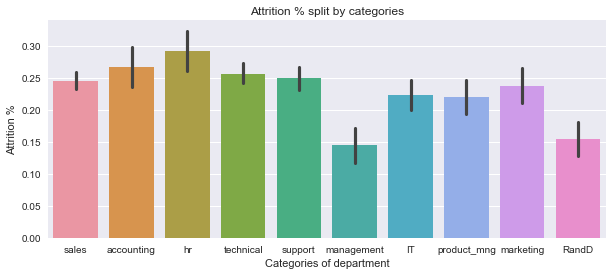

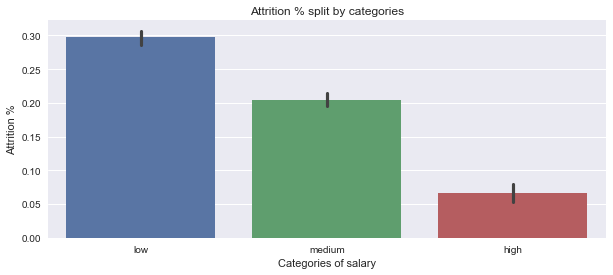

In [9]:
bp = PdfPages('Attrition Plots by Categorical Variable.pdf')

for cat_variable in cat_list:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=cat_variable,y='left',data=hrdf) 
    sns.plt.ylabel('Attrition %')
    sns.plt.xlabel(str('Categories of ') + str(cat_variable))
    sns.plt.title('Attrition % split by categories')
    bp.savefig(fig)

bp.close()

###### 2.3 Data Exploratory Analysis
    - Variable Transformation: (i) Standard Transformations

In [10]:
# 4 transformations = X, X_squared, X_sqrt, X_ln
hrdf_transform = hrdf[num_list].copy()
squared = (hrdf_transform**2).add_suffix("_squared")
square_root = (hrdf_transform**0.5).add_suffix("_sqrt")
natural_log = np.log(hrdf_transform+1).add_suffix("_ln")
hrdf_transform = pd.concat([hrdf_transform, squared, square_root, natural_log], axis=1)
hrdf_transform.drop(['left_squared','left_ln','left_sqrt'], axis=1, inplace=True)
hrdf_transform.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,satisfaction_level_squared,last_evaluation_squared,...,time_spend_company_sqrt,Work_accident_sqrt,promotion_last_5years_sqrt,satisfaction_level_ln,last_evaluation_ln,number_project_ln,average_montly_hours_ln,time_spend_company_ln,Work_accident_ln,promotion_last_5years_ln
0,0.38,0.53,2,157,3,0,1,0,0.1444,0.2809,...,1.732051,0.0,0.0,0.322083,0.425268,1.098612,5.062595,1.386294,0.0,0.0
1,0.80,0.86,5,262,6,0,1,0,0.6400,0.7396,...,2.449490,0.0,0.0,0.587787,0.620576,1.791759,5.572154,1.945910,0.0,0.0
2,0.11,0.88,7,272,4,0,1,0,0.0121,0.7744,...,2.000000,0.0,0.0,0.104360,0.631272,2.079442,5.609472,1.609438,0.0,0.0
3,0.72,0.87,5,223,5,0,1,0,0.5184,0.7569,...,2.236068,0.0,0.0,0.542324,0.625938,1.791759,5.411646,1.791759,0.0,0.0
4,0.37,0.52,2,159,3,0,1,0,0.1369,0.2704,...,1.732051,0.0,0.0,0.314811,0.418710,1.098612,5.075174,1.386294,0.0,0.0


In [11]:
llf_df = pd.DataFrame()
for num_variable in hrdf_transform.columns.difference(['left']):
    logreg = sm.logit(formula = str('left ~ ')+str(num_variable), data=hrdf_transform)
    result = logreg.fit()
    summ = result.summary()
    temp = pd.DataFrame([num_variable, result.llf]).T
    temp.columns = ['Variable Name','Log-Likelihood Full']
    llf_df = pd.concat([llf_df, temp], axis=0)

llf_df

### There is no need to transform the raw input numerical variables as the Gini values is independent of the transformation

Optimization terminated successfully.
         Current function value: 0.534317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548856
  

,Variable Name,Log-Likelihood Full
0,Work_accident,-8014.23
0,Work_accident_ln,-8014.23
0,Work_accident_sqrt,-8014.23
0,Work_accident_squared,-8014.23
0,average_montly_hours,-8194.2
0,average_montly_hours_ln,-8220.92
0,average_montly_hours_sqrt,-8209.92
0,average_montly_hours_squared,-8149.22
0,last_evaluation,-8232.02
0,last_evaluation_ln,-8232.29


###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


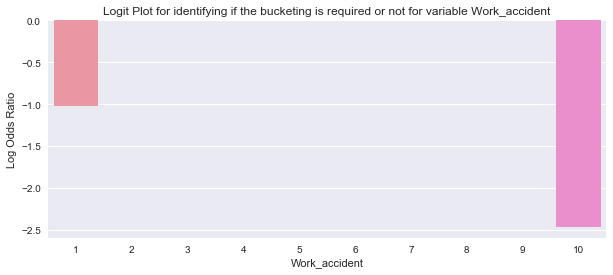

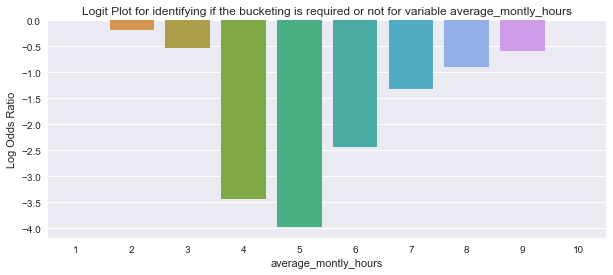

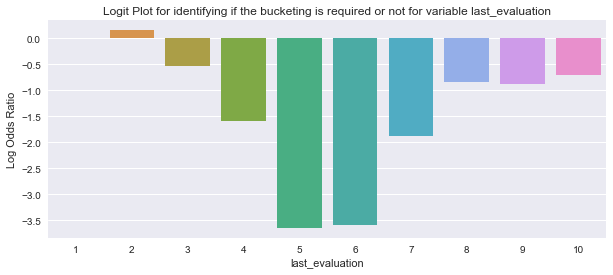

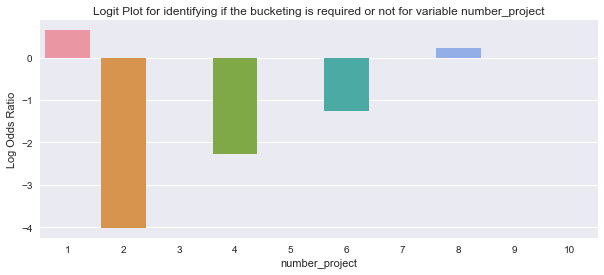

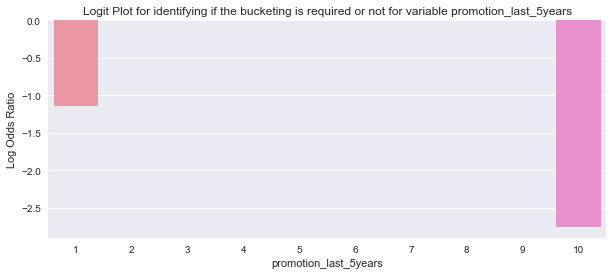

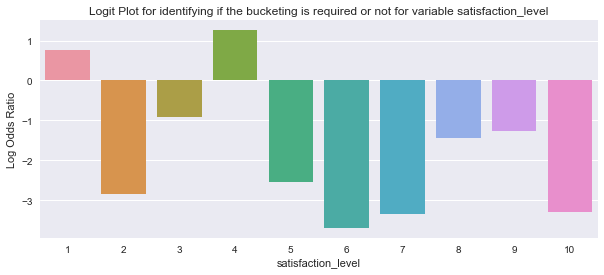

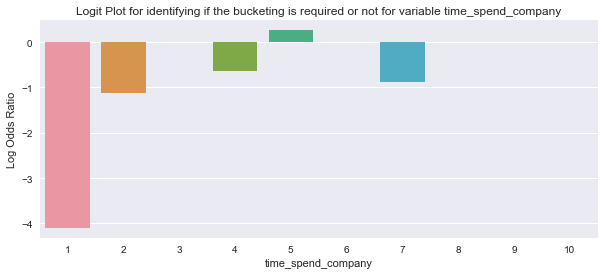

In [12]:
bp = PdfPages('Transformation Plots.pdf')

for num_variable in hrdf.columns.difference(['left','salary','department']):
    binned = pd.cut(hrdf[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = hrdf.groupby(binned)['left'].sum() / (hrdf.groupby(binned)['left'].count()-hrdf.groupby(binned)['left'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    sns.plt.ylabel('Log Odds Ratio')
    sns.plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()


In [13]:
print('Two variables need bucketing - avgerage_montly_hours and last_evaluation')
hrdf.columns

Two variables need bucketing - avgerage_montly_hours and last_evaluation


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [14]:
hrdf[['average_montly_hours', 'last_evaluation']].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
average_montly_hours,14999.0,201.050337,49.943099,96.00,137.00,150.00,162.00,181.00,200.00,220.00,238.00,253.00,267.00,310.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.49,0.54,0.59,0.65,0.72,0.78,0.84,0.89,0.95,1.0


In [15]:
# monthly hours bucekting
hrdf['monthly_hrs_extreme'] = hrdf['average_montly_hours'].apply(lambda x: 0 if 162 < x < 221 else 1)
hrdf['last_evaluation_extreme'] = hrdf['last_evaluation'].apply(lambda x: 0 if 0.6 <= x < 0.84 else 1)
hrdf['last_evaluation_extreme'].value_counts()

1    9470
0    5529
Name: last_evaluation_extreme, dtype: int64

In [16]:
# num_project_grp
hrdf['number_project_grp'] = hrdf['number_project'].clip_lower(3)

In [17]:
## Bucketing for sales or department variable
department_grp = hrdf[['department','left']].groupby('department').sum() / hrdf[['department','left']].groupby('department').count()
print(department_grp.sort_values('left'))
hrdf['dept_grp'] = hrdf['department'].apply(lambda x: 'Low' if x in ['management', 'RandD'] else 
                   'medium' if x in ['product_mng', 'IT', 'marketing', 'sales', 'support', 'technical'] else 'high')

                 left
department           
management   0.144444
RandD        0.153748
product_mng  0.219512
IT           0.222494
marketing    0.236597
sales        0.244928
support      0.248991
technical    0.256250
accounting   0.265971
hr           0.290934


###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [18]:
hrdf.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'department', 'salary', 'monthly_hrs_extreme',
       'last_evaluation_extreme', 'number_project_grp', 'dept_grp'],
      dtype='object')

In [19]:
## Both department and salary buckets are important variables as seen from ChiSquare values
##### cat final variables = dept_grp and salary
num_features = ['satisfaction_level', 'time_spend_company', 'Work_accident', 
               'promotion_last_5years', 'monthly_hrs_extreme', 'last_evaluation_extreme', 'number_project_grp']
somersd_df = pd.DataFrame()
for num_variable in num_features:
    logreg = sm.logit(formula = str('left ~ ')+str(num_variable), data=hrdf)
    result = logreg.fit()
    summ = result.summary()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(hrdf['left'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

Optimization terminated successfully.
         Current function value: 0.473291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533548
         Iterations 5


,Variable Name,SomersD
0,satisfaction_level,0.495877
0,time_spend_company,0.346659
0,Work_accident,0.127683
0,promotion_last_5years,0.0209307
0,monthly_hrs_extreme,0.341999
0,last_evaluation_extreme,0.316949
0,number_project_grp,0.125739


###### 2.6 Data Exploratory Analysis
    - Multicollinearity

In [20]:
# promotion_last_5years is dropped due to Somer's D < 5%
get_dummies = pd.get_dummies(data=hrdf['dept_grp'], prefix='dept', drop_first=True)
hrdf = pd.concat([hrdf, get_dummies], axis=1)


get_dummies = pd.get_dummies(data=hrdf['salary'], prefix='salary', drop_first=True)
pd.concat([hrdf, get_dummies], axis=1)
hrdf = pd.concat([hrdf, get_dummies], axis=1)

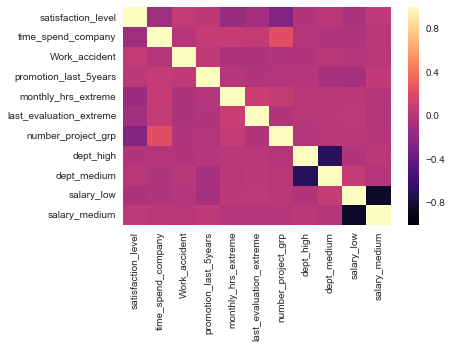

In [21]:
num_dummy_features = ['satisfaction_level', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 
                      'monthly_hrs_extreme', 'last_evaluation_extreme', 'number_project_grp',
                      'dept_high', 'dept_medium', 'salary_low', 'salary_medium']
sns.heatmap(hrdf[num_dummy_features].corr(),cmap='magma')

## Conclusion - number of projects, time sepnt in company are correlated
## similarly salary binary indicators are mildly correlated ... which is expected

In [22]:
## Variance Inflation Factor assessment
X = pd.concat([hrdf[num_dummy_features],hrdf['left']], axis=1)
#X['intercept']=1
# y, X = dmatrices('annual_inc ~' + features, df, return_type='dataframe')
features = "+".join(num_dummy_features)
#features = features + "+intercept"
X.head()

,satisfaction_level,time_spend_company,Work_accident,promotion_last_5years,monthly_hrs_extreme,last_evaluation_extreme,number_project_grp,dept_high,dept_medium,salary_low,salary_medium,left
0,0.38,3,0,0,1,1,3,0,1,1,0,1
1,0.80,6,0,0,1,1,5,0,1,0,1,1
2,0.11,4,0,0,1,1,7,0,1,0,1,1
3,0.72,5,0,0,1,1,5,0,1,1,0,1
4,0.37,3,0,0,1,1,3,0,1,1,0,1


In [23]:
a,b = dmatrices(formula_like='left ~ '+ features, data = X, return_type='dataframe')
b.drop('salary_medium', axis=1, inplace=True)

In [24]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

In [25]:
print(vif)

## vif < 3 except for salary which is expected. 
## salary_medium to be dropped and only salary_low is kept in the final model features for model build

num_dummy_features = b.columns[1:]   # dropping intercept
num_dummy_features
X.columns

    VIF Factor                 features
0    48.199503                Intercept
1     1.103055       satisfaction_level
2     1.071434       time_spend_company
3     1.008375            Work_accident
4     1.023297    promotion_last_5years
5     1.033494      monthly_hrs_extreme
6     1.023114  last_evaluation_extreme
7     1.118236       number_project_grp
8     1.875279                dept_high
9     1.890555              dept_medium
10    1.015745               salary_low


Index(['satisfaction_level', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'monthly_hrs_extreme',
       'last_evaluation_extreme', 'number_project_grp', 'dept_high',
       'dept_medium', 'salary_low', 'salary_medium', 'left'],
      dtype='object')

#### 3.1 Model Build and Diagnostics
 - Train and Test split

In [26]:
X.drop('salary_medium', axis=1, inplace=True)
train_features = X.columns.difference(['left'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

Index(['satisfaction_level', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'monthly_hrs_extreme',
       'last_evaluation_extreme', 'number_project_grp', 'dept_high',
       'dept_medium', 'salary_low', 'left'],
      dtype='object')

#### 3.2 Model Build and Diagnostics
    - Model build on the train_X sample

In [27]:
logreg = sm.logit(formula='left ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()
summ = result.summary()
summ

## All of the model variables are significant

Optimization terminated successfully.
         Current function value: 0.345502
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                10499
Model:                          Logit   Df Residuals:                    10488
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Sep 2017   Pseudo R-squ.:                  0.3704
Time:                        08:59:35   Log-Likelihood:                -3627.4
converged:                       True   LL-Null:                       -5761.7
                                        LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.4533      0.234    -23.267      0.000      -5.913      -4.994
Work_accident              -1.4999      0.115    -13.038      0.000      -1.725      -1.274
dept_high                   0.8311      0.141      5.910      0.000       0.555       1.107
dept_medium                 0.6421      0.115      5.583      0.000       0.417       0.868
last_evaluation_extreme     1.9995      0.081     24.753      0.000       1.841       2.158
monthly_hrs_extreme         2.7699      0.116     23.948      0.000       2.543       2.997
number_project_grp          0.1736      0.029      6.051      0.000       0.117       0.230
promotion_last_5years      -1.3748      0.319     -4.312      0.000      -2.000      -0.750
salary_low                  0.6754      0.059     11.410      0.000       0.559       0.791
satisfaction_level         -3.8568      0.127    -30.324      0.000      -4.106      -3.608
time_spend_company          0.3061      0.023     13.384      0.000       0.261       0.351
===========================================================================================
"""

In [28]:
train_gini = 2*metrics.roc_auc_score(train_X['left'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

The Gini Index for the model built on the Train Data is :  0.788933523409


In [29]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['left']
# making a DataFrame with actual and prob columns
hr_train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
hr_train_predict.columns = ['actual','prob']
hr_train_predict.head()

,actual,prob
12602,1,0.936274
4889,0,0.008417
1572,1,0.638421
13375,0,0.025775
879,1,0.308754


In [31]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = hr_train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0 if x < cut_off else 1)
    train_temp['tp'] = train_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==1 else 0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==1 else 0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==0 else 0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==0 else 0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)

train_temp.sum()

actual       2499.0
prob         2499.0
predicted       0.0
tp              0.0
fp              0.0
tn           8000.0
fn           2499.0
dtype: float64

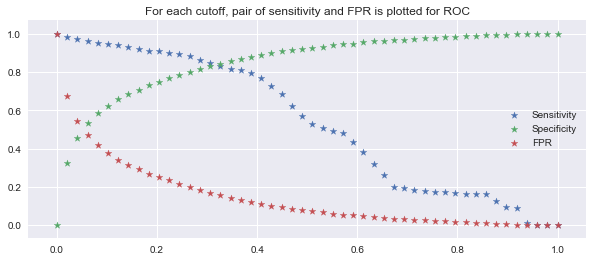

In [32]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [33]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.265306,0.885154,0.79925,1.684404


#### 4.1 Model Validation
    - Coefficient Stability - sign and p-values

In [34]:
##1. Checking the coefficient stability on validation sample
logreg_test = sm.logit(formula='left ~ ' + "+".join(train_features), data=test_X)
result_test = logreg_test.fit()
summ_test = result_test.summary()
summ_test

Optimization terminated successfully.
         Current function value: 0.357944
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 4500
Model:                          Logit   Df Residuals:                     4489
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Sep 2017   Pseudo R-squ.:                  0.3480
Time:                        09:05:40   Log-Likelihood:                -1610.8
converged:                       True   LL-Null:                       -2470.6
                                        LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -4.9584      0.350    -14.175      0.000      -5.644      -4.273
Work_accident              -1.6065      0.183     -8.794      0.000      -1.965      -1.248
dept_high                   0.4960      0.208      2.387      0.017       0.089       0.903
dept_medium                 0.3360      0.172      1.948      0.051      -0.002       0.674
last_evaluation_extreme     1.9130      0.120     15.976      0.000       1.678       2.148
monthly_hrs_extreme         2.6146      0.166     15.723      0.000       2.289       2.941
number_project_grp          0.0974      0.043      2.273      0.023       0.013       0.181
promotion_last_5years      -1.3450      0.504     -2.667      0.008      -2.333      -0.357
salary_low                  0.7421      0.089      8.306      0.000       0.567       0.917
satisfaction_level         -3.5444      0.189    -18.740      0.000      -3.915      -3.174
time_spend_company          0.3307      0.034      9.758      0.000       0.264       0.397
===========================================================================================
"""

#### 4.2 Model Validation 
    - Gini metric comparison

In [35]:
train_gini = 2*metrics.roc_auc_score(train_X['left'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)
test_gini = 2*metrics.roc_auc_score(test_X['left'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.788933523409
The Gini Index for the model built on the Test Data is :  0.7684275893


#### 4.3 Model Validation
    - Cut-Off based sensitivity comparison

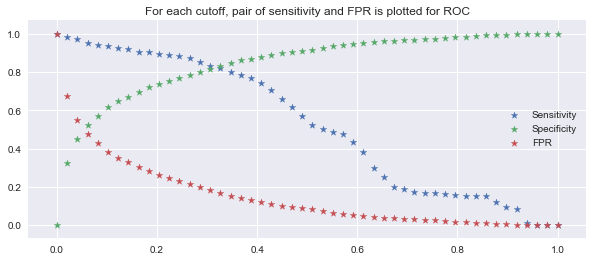

In [36]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['left']
# making a DataFrame with actual and prob columns
hr_test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
hr_test_predict.columns = ['actual','prob']
hr_test_predict.head()

## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
test_roc_like_df = pd.DataFrame()
test_temp = hr_test_predict.copy()

for cut_off in np.linspace(0,1,50):
    test_temp['predicted'] = test_temp['prob'].apply(lambda x: 0 if x < cut_off else 1)
    test_temp['tp'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==1 else 0, axis=1)
    test_temp['fp'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==1 else 0, axis=1)
    test_temp['tn'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==0 else 0, axis=1)
    test_temp['fn'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==0 else 0, axis=1)
    sensitivity = test_temp['tp'].sum() / (test_temp['tp'].sum() + test_temp['fn'].sum())
    specificity = test_temp['tn'].sum() / (test_temp['tn'].sum() + test_temp['fp'].sum())
    test_roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    test_roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    test_roc_like_df = pd.concat([test_roc_like_df, test_roc_like_table], axis=0)

test_temp.sum()
plt.subplots(figsize=(10,4))
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(test_roc_like_df['cutoff'], 1-test_roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [37]:
## Finding ideal cut-off for checking if this remains same in OOS validation
test_roc_like_df['total'] = test_roc_like_df['sensitivity'] + test_roc_like_df['specificity']
test_roc_like_df[test_roc_like_df['total']==test_roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.265306,0.872201,0.785006,1.657207


#### 4.4 Model Validation
    - Confusion Table metrics for the same cut-off

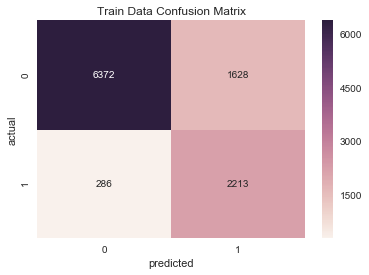

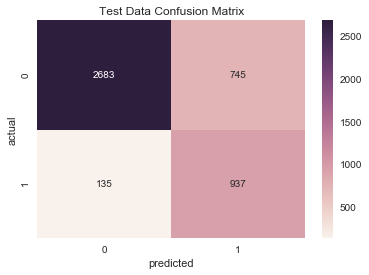

In [38]:
hr_test_predict['predicted'] = hr_test_predict['prob'].apply(lambda x: 1 if x > 0.26 else 0)
hr_train_predict['predicted'] = hr_train_predict['prob'].apply(lambda x: 1 if x > 0.26 else 0)
sns.heatmap(pd.crosstab(hr_train_predict['actual'], hr_train_predict['predicted']), annot=True, fmt='.0f')
sns.plt.title('Train Data Confusion Matrix')
sns.plt.show()
sns.heatmap(pd.crosstab(hr_test_predict['actual'], hr_test_predict['predicted']), annot=True, fmt='.0f')
sns.plt.title('Test Data Confusion Matrix')
sns.plt.show()
# (2683+937)/(2683+745+135+937)

In [39]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(hr_train_predict.actual, hr_train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(hr_test_predict.actual, hr_test_predict.predicted))

The overall accuracy score for the Train Data is :  0.817696923517
The overall accuracy score for the Test Data  is :  0.804444444444


#### 4.5 Model Validation
    - Accuracy with respect to interpretation as probablity score

In [40]:
print(hr_train_predict[['actual', 'prob']].sum(axis=0))
print(hr_test_predict[['actual', 'prob']].sum(axis=0))  
## not a major problem with accuracy at test overall level

actual    2499.0
prob      2499.0
dtype: float64
actual    1072.000000
prob      1084.211815
dtype: float64


#### 5. Model Properties
    - unbiased
    - reliable
    - stable
    - accurate - overall for test sample (HL test not done)
    - rankordering - Gini (Done) and KS (not done)
 
This leads to the conclusion that the model score can be used safely as a probabilistic score for both targeting and PnL calculation

In [61]:
deciles = pd.cut(hr_train_predict.prob, bins=10, labels=list(range(1,11)))
hr_train_predict.groupby(deciles)['prob'].min().sort_index(ascending=False)
hr_train_predict.groupby(deciles)['prob'].max().sort_index(ascending=False)
hr_train_predict.groupby(deciles)['actual'].sum().sort_index(ascending=False)
hr_train_predict.groupby(deciles)['actual'].count().sort_index(ascending=False)

prob
10     387
9      202
8      169
7      840
6      543
5      817
4      653
3      744
2     1101
1     5043
Name: actual, dtype: int64